# **scNET: Learning Context-Specific Gene and Cell Embeddings by Integrating Single-Cell Gene Expression Data with Protein-Protein Interaction Information**

**Install scnet using pip**

In [47]:
!pip install -i https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple scnet==0.1.9.9.2


Looking in indexes: https://test.pypi.org/simple/, https://pypi.org/simple
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 10.7 MB/s eta 0:00:00
  Attempting uninstall: scnet
    Found existing installation: scnet 0.1.9.9.1
    Uninstalling scnet-0.1.9.9.1:
      Successfully uninstalled scnet-0.1.9.9.1


**Download example data**

In [2]:
import gdown
download_url = f'https://drive.google.com/uc?id=1CQu1aZDVfLSu4Tfuj5Qv3HGw-RnHAWIL'
output_path = './example.h5ad'
gdown.download(download_url, output_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1CQu1aZDVfLSu4Tfuj5Qv3HGw-RnHAWIL
From (redirected): https://drive.google.com/uc?id=1CQu1aZDVfLSu4Tfuj5Qv3HGw-RnHAWIL&confirm=t&uuid=b008583e-d0f5-4376-9540-e843c3082bb2
To: /content/example.h5ad
100%|██████████| 1.38G/1.38G [00:10<00:00, 127MB/s]


'./example.h5ad'

# Import scNET and model traning

## run_scNET arguments:
 **obj (AnnData, optional):** AnnData obj.

  **pre_processing_flag (bool, optional):** If True, perform pre-processing steps.

  **human_flag (bool, optional):** Controls gene name casing in the network.

  **number_of_batches (int, optional):** Number of mini-batches for the training.

  **split_cells (bool, optional):** If True, split by cells instead of edges during training. If using A100 could be True

  **n_neighbors (int, optional):** Number of neighbors for building the adjacency graph.

  **max_epoch (int, optional):** Max number of epochs for model training.

  **model_name (str, optional):** Identifier for saving the model outputs.
  
  **save_model_flag (bool, optional):** If True, save the trained model.

In [4]:
import scNET
import scanpy as sc
obj = sc.read_h5ad("./example.h5ad")
scNET.run_scNET(obj, pre_processing_flag=False, human_flag=False, number_of_batches=10, split_cells=True, max_epoch=300, model_name = "test")



# Using the model's outputs

**Load all the relevant embeddings**


In [2]:
embedded_genes, embedded_cells, node_features , out_features =  scNET.load_embeddings("test")

/content
/usr/local/lib/python3.11/dist-packages/scNET/content


**Create Scanpy object based on the reconstructed gene expression**


In [5]:
cell_types = {"0":"Macrophages","1":"Macrophages","2":"CD8 Tcells","3":"Microglia","4":"Cancer","5":"CD4 Tcells","6":"B Cells","10":"Prolifrating Tcells","8":"Cancer","11":"NK"}
obj.obs["Cell Type"] = obj.obs.seurat_clusters.map(cell_types)
recon_obj = scNET.create_reconstructed_obj(node_features, out_features, obj)

**Plot marker genes**

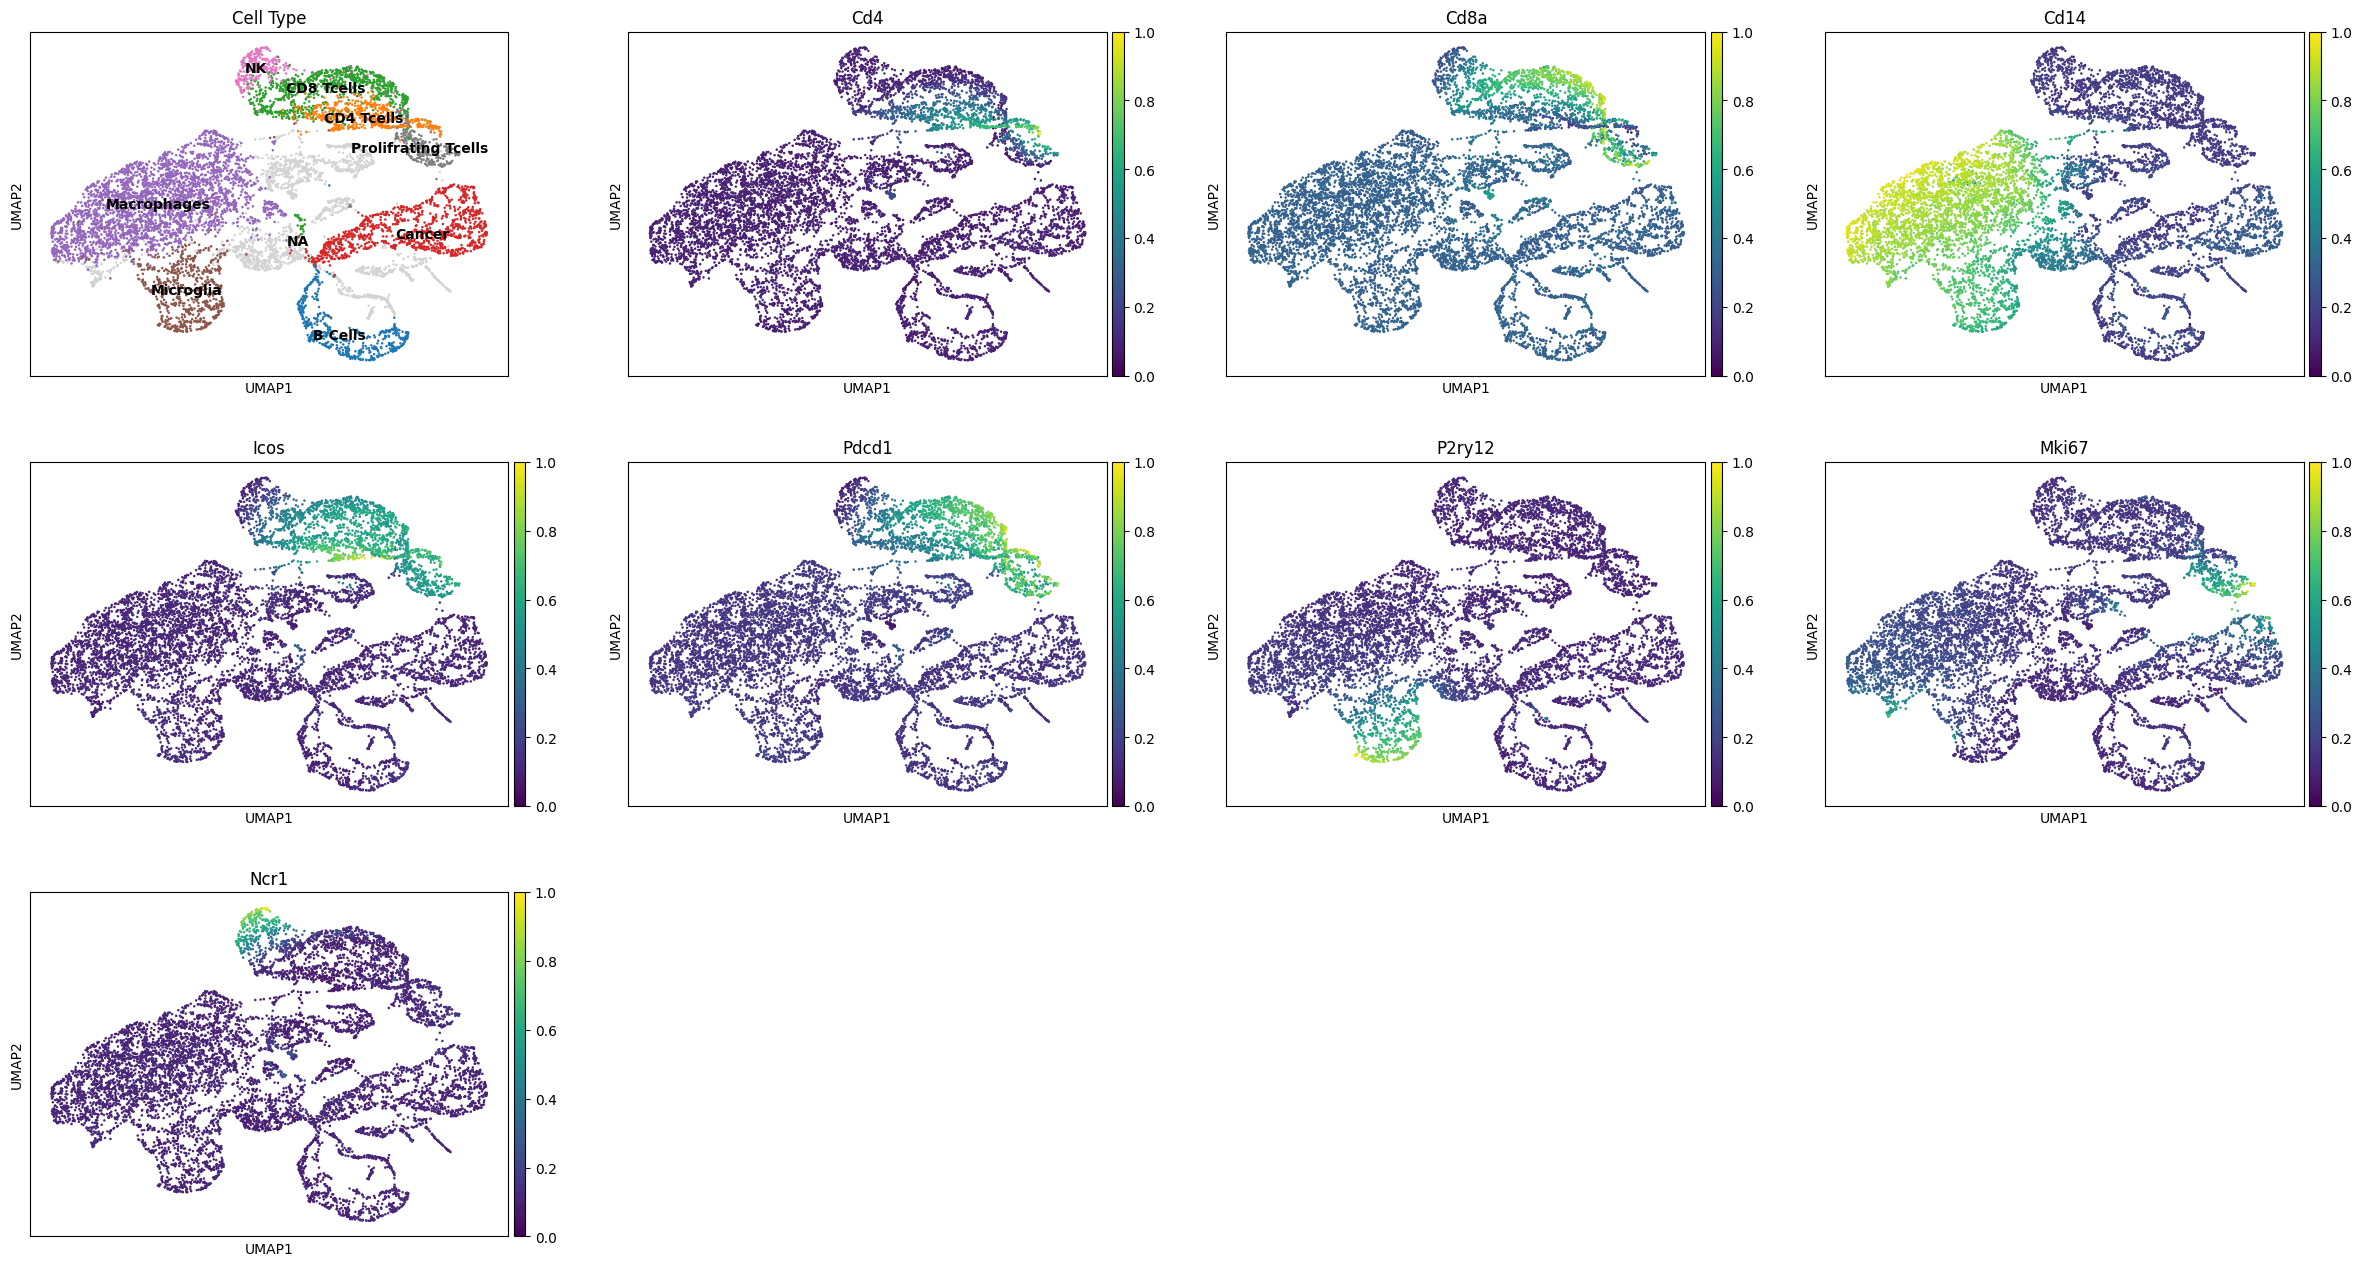

In [6]:
sc.pl.umap(recon_obj, color=["Cell Type","Cd4","Cd8a","Cd14","Icos","Pdcd1","P2ry12","Mki67","Ncr1"], show=True, legend_loc='on data')

**Propagation based signature projection for actvation of Tcells**



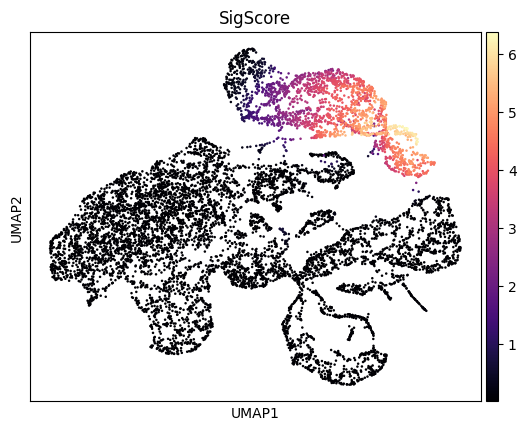

array([3.83459528e+00, 1.42513784e-02, 1.31545689e-03, ...,
       3.80410133e+00, 1.39804817e-02, 1.43595773e-02])

In [10]:
scNET.run_signature(recon_obj,up_sig=["Zap70","Lck","Fyn","Cd3g","Cd28","Lat"],alpha = 0.9)

**And for Tumor aggression**

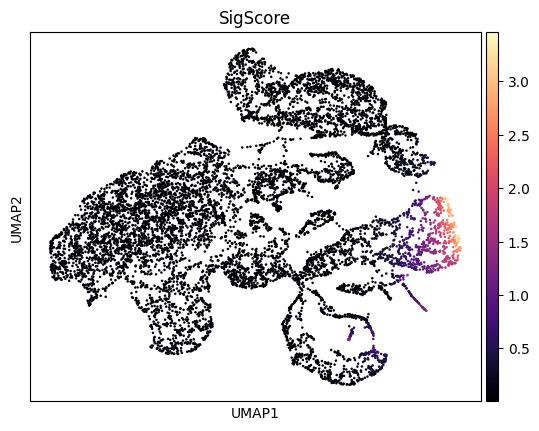

array([0.04498904, 0.2093147 , 0.3695143 , ..., 0.06291617, 0.00505507,
       0.26942734])

In [11]:

scNET.run_signature(recon_obj,up_sig=["Cdkn2a","Myc","Pten","Kras"])


**Creating the co-embedded network, is it modular?**

In [13]:
import networkx as nx
net, mod = scNET.build_co_embeded_network(embedded_genes, node_features)
print(f"The network mdularity: {mod}")

The network mdularity: 0.7884569102167771


**Now we can use the network to predict KEGG pathway membership in a cross-validation**

Thus showin the utilities of the co embeded netowrk

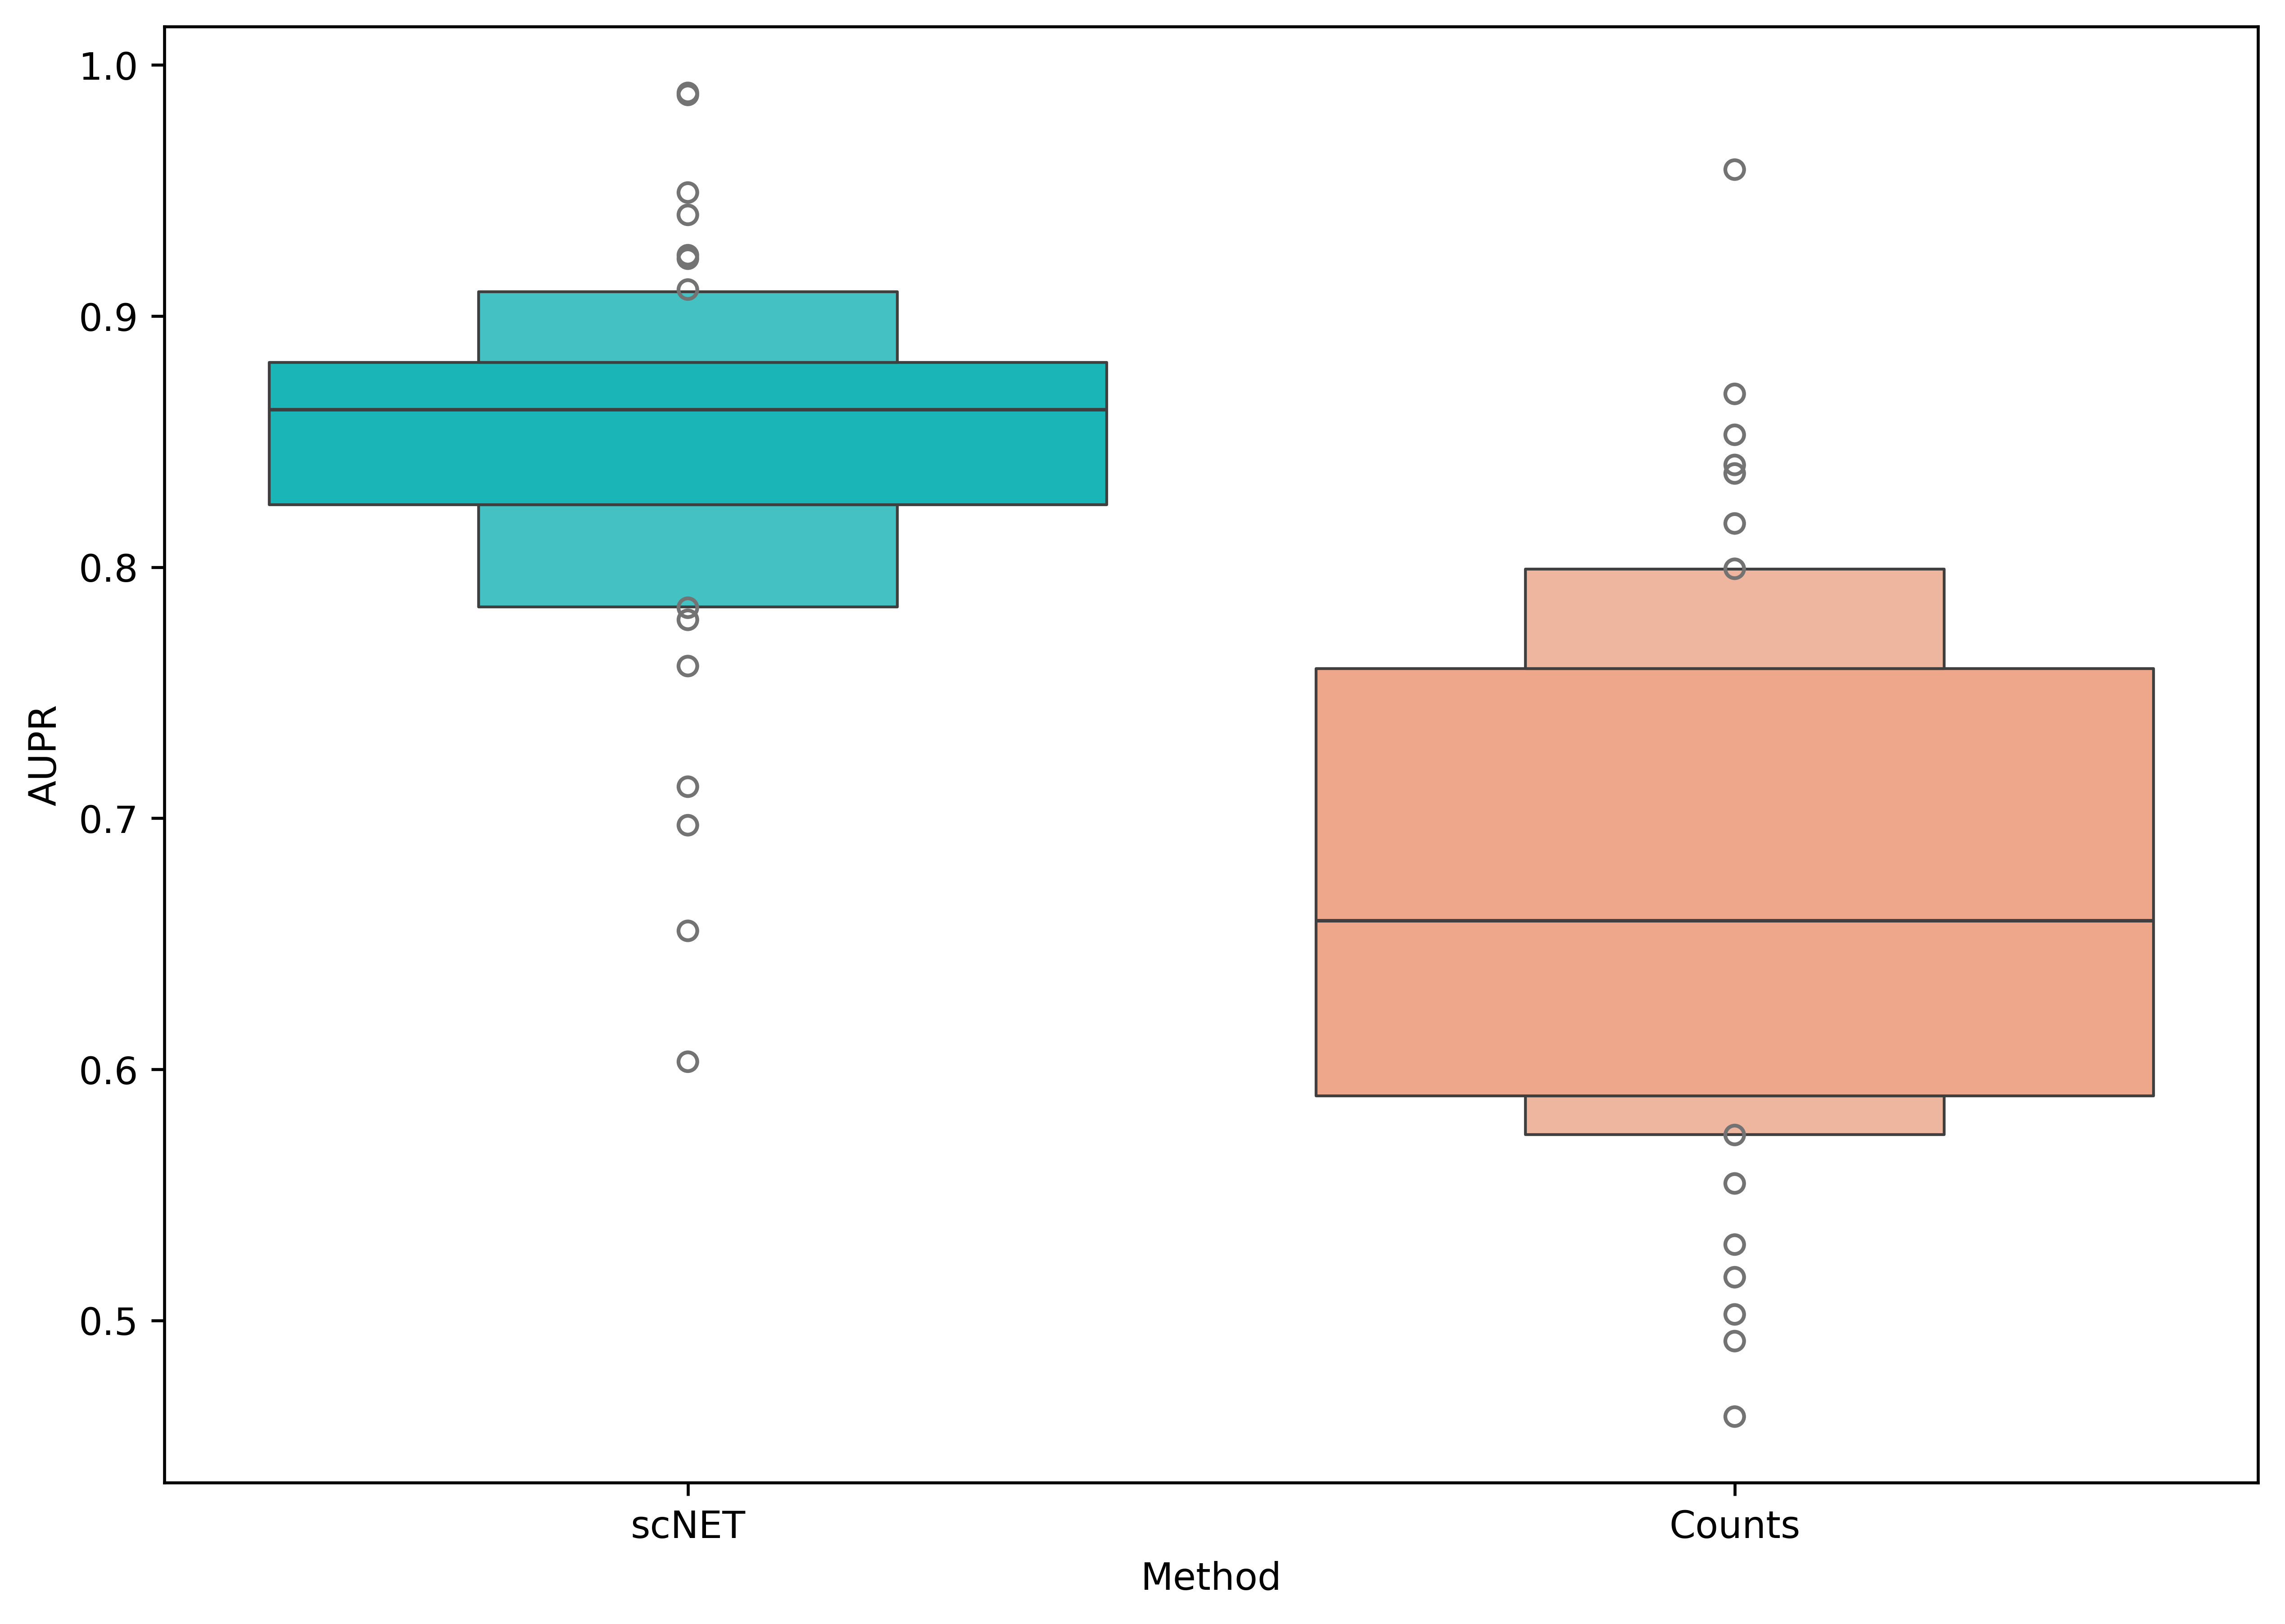

,AUPR,Method
0,0.864651,scNET
1,0.822338,scNET
2,0.832322,scNET
3,0.655141,scNET
4,0.910562,scNET
...,...,...
95,0.817394,Counts
96,0.502367,Counts
97,0.623232,Counts
98,0.733333,Counts


In [17]:
scNET.test_KEGG_prediction(embedded_genes, node_features)

**Finding differential enriched pathways**

<Figure size 1000x3000 with 0 Axes>

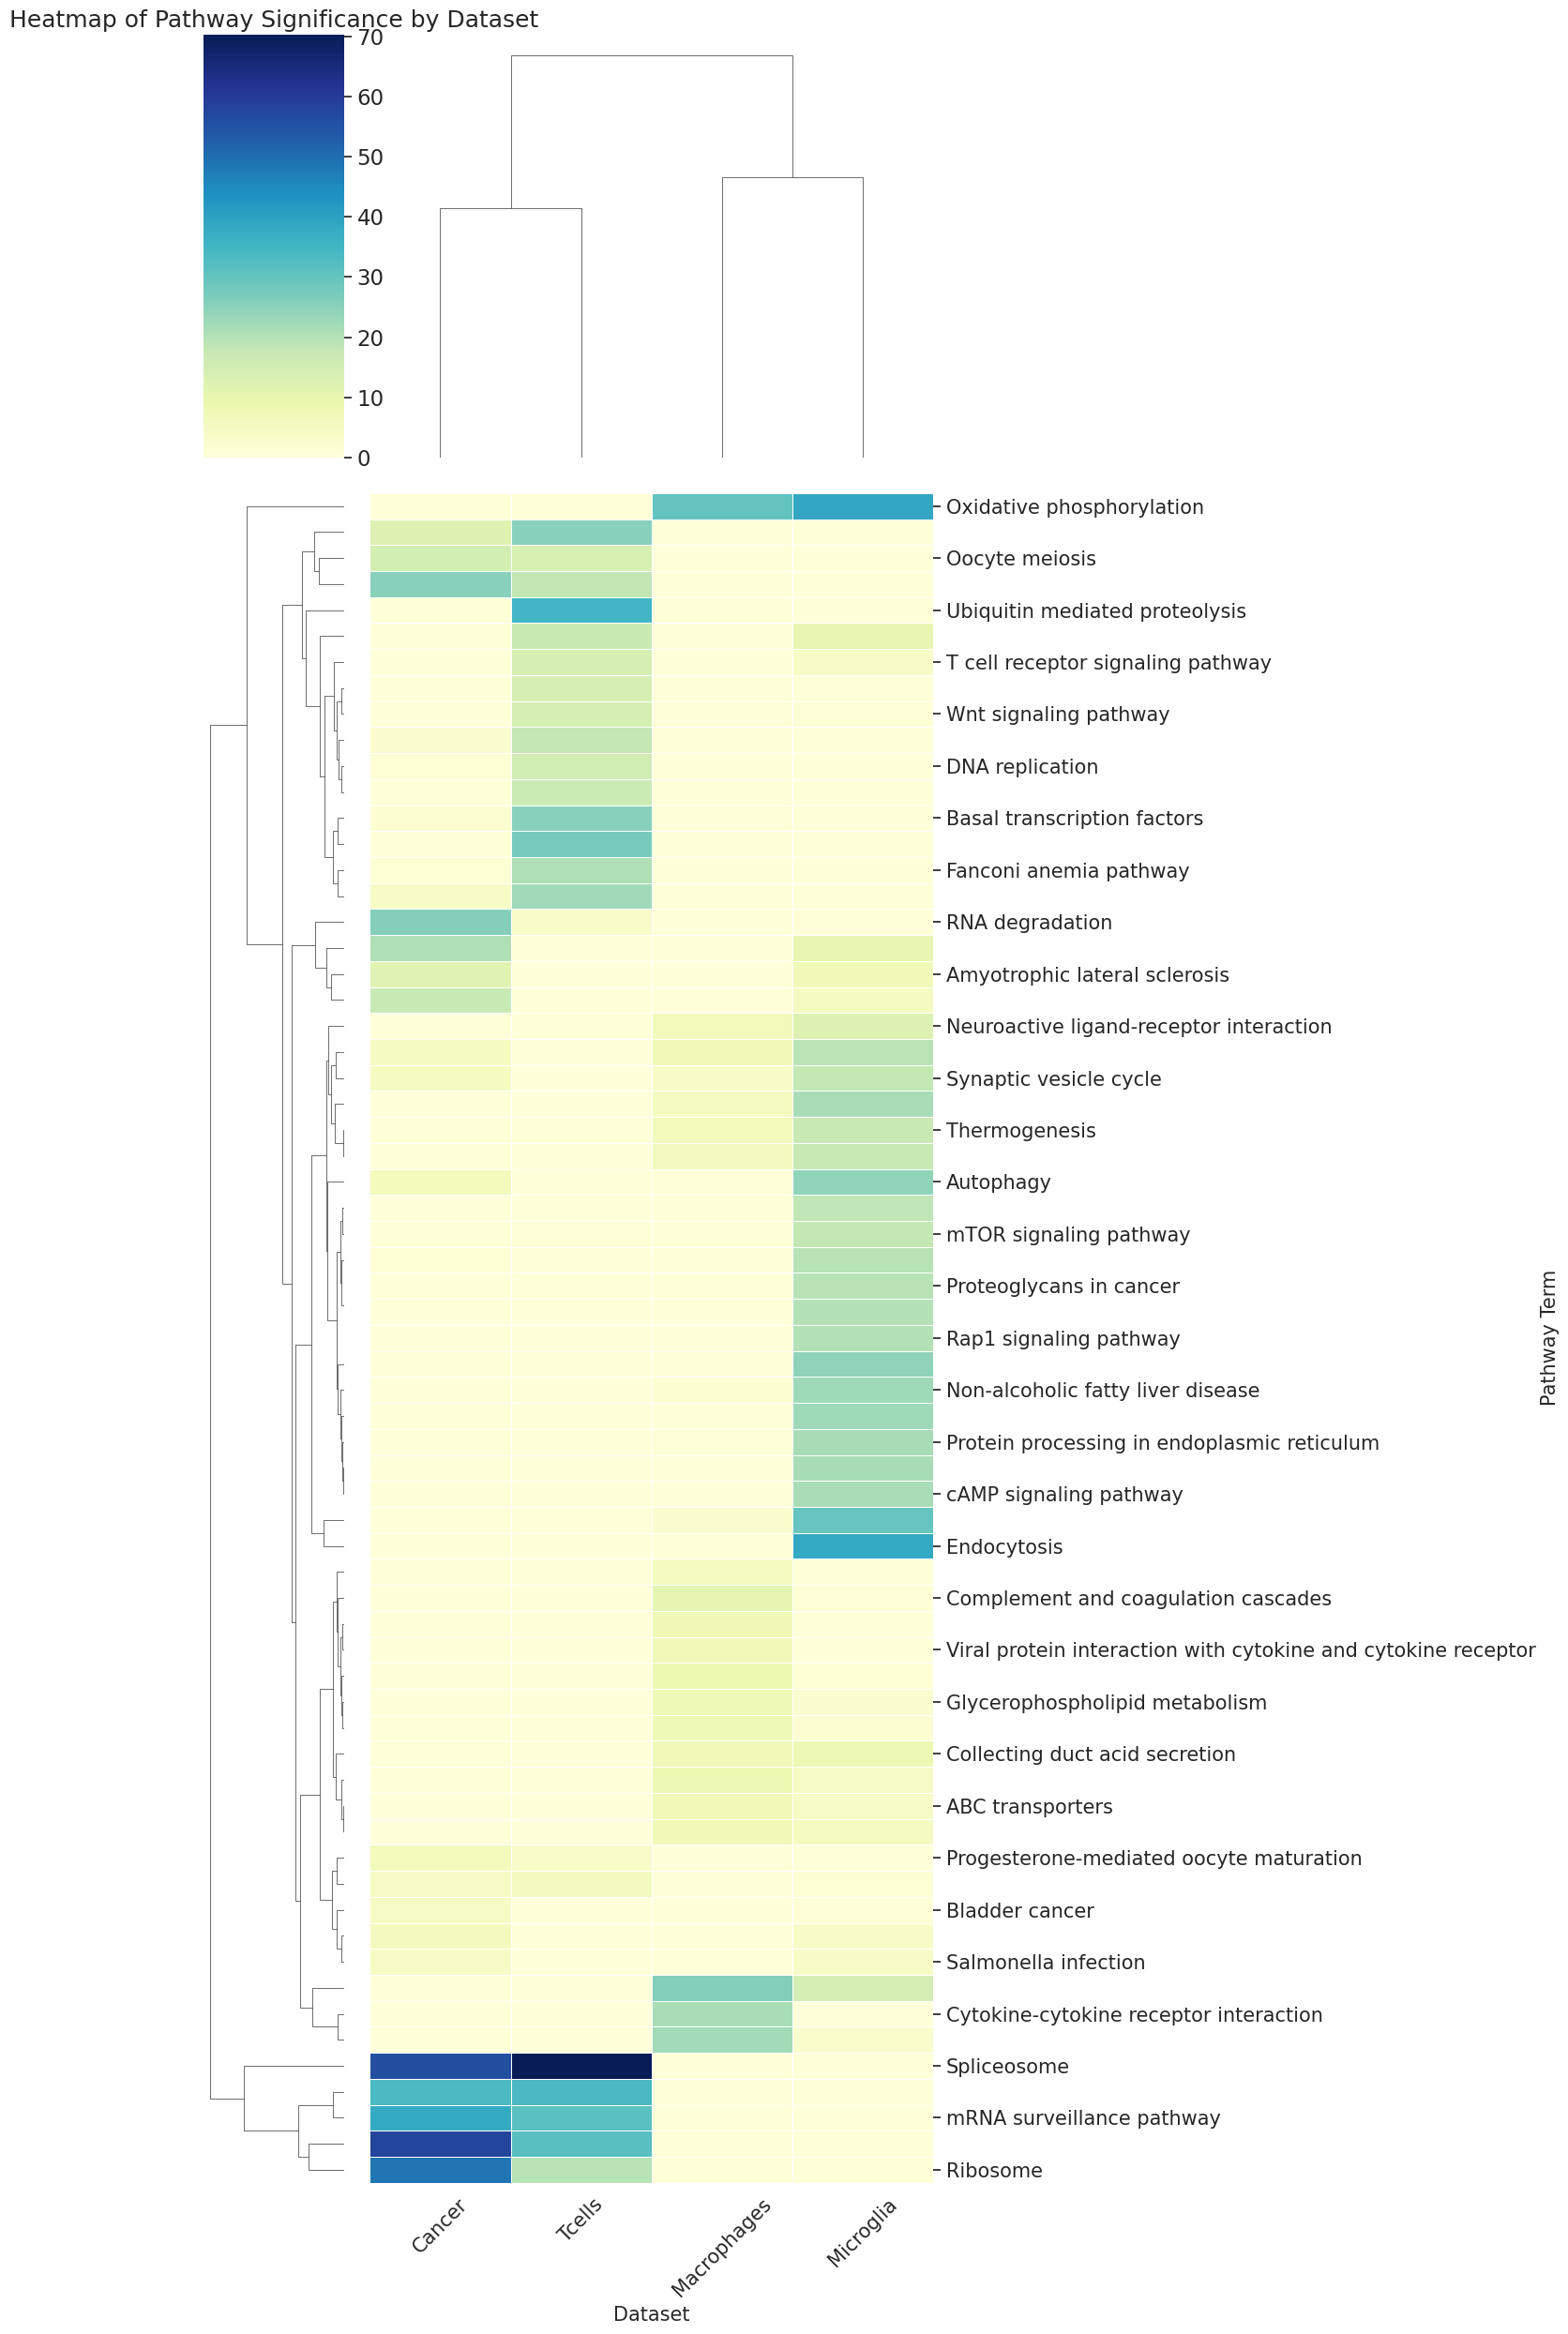

In [11]:
recon_obj.obs["Cell Type"] = recon_obj.obs["Cell Type"].apply(lambda x: "Tcells" if not x is None and str(x).find("Tcell") >=0 else x )

de_genes_per_group, significant_pathways, filtered_kegg, enrichment_results= scNET.pathway_enricment(recon_obj.copy()[recon_obj.obs["Cell Type"].isin(["Macrophages","Tcells","Cancer","Microglia"])],groupby="Cell Type")
scNET.plot_de_pathways(significant_pathways,enrichment_results)